In [3]:
import os
from multiprocessing import Process, Queue
from sklearn.neighbors import NearestNeighbors
import pandas as pd
os.putenv('CODA_DEFINITION', '/home/mmueller/hiwi/aeolus/')

import coda
from numpy import vstack, zeros
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use("Agg")
import pyproj
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString
import sys, os


from radarlidar_analysis.RadarLidarWindSpeed import RadarLidarWindSpeed
from datetime import datetime, timedelta
import tarfile
import math



path = '/work/marcus_mueller/aeolus/3058/'

In [4]:
def calculate_nearest(row, destination, val, col='geometry'):
    # 1 - create unary union    
    dest_unary = destination['geometry'].unary_union
    # 2 - find closest point
    nearest_geom = nearest_points(row[col], dest_unary)
    # 3 - Find the corresponding geom
    match_geom = destination.loc[destination.geometry 
                == nearest_geom[1]]
    # 4 - get the corresponding value
    match_value = match_geom[val].to_numpy()[0]
    return match_value
def create_gdf(df, x='lat', y='lon'):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[y], df[x]), crs={'init':'EPSG:4326'})

In [18]:
filename = 'AE_OPER_ALD_U_N_2B_20201129T171747_20201129T194059_0001'
print(filename)
tf = tarfile.open(path+filename+".TGZ", "r:gz")
tf.extractall(path)
tf.close()
sys.path.append(path)

try:
    product = coda.open(path+filename+".DBL")
    latitude = coda.fetch(product, 'rayleigh_geolocation', -1, 'windresult_geolocation/latitude_cog')

    longitude = coda.fetch(product, 'rayleigh_geolocation', -1, 'windresult_geolocation/longitude_cog')

    altitude = coda.fetch(product, 'rayleigh_geolocation', -1, 'windresult_geolocation/altitude_vcog')




    rayleigh_wind_velocity = coda.fetch(product, 'rayleigh_hloswind', -1, 'windresult/rayleigh_wind_velocity')
    rayleigh_wind_validity = coda.fetch(product, 'rayleigh_hloswind', -1, 'windresult/validity_flag')

    rayleigh_wind_velocity = rayleigh_wind_velocity*0.01#*0.01
    #rayleigh_wind_result_wind_velocity

    result_id = coda.fetch(product, 'rayleigh_profile', -1, 'l2b_wind_profiles/wind_result_id_number')
    time = coda.fetch(product, 'rayleigh_profile', -1, 'Start_of_Obs_DateTime')
    orbit = coda.fetch(product, 'rayleigh_geolocation', -1, 'windresult_geolocation/altitude_vcog')
    azimuth = coda.fetch(product, 'rayleigh_geolocation', -1, 'windresult_geolocation/los_azimuth')


    result_id = vstack(result_id)

    wind_velocity = zeros(result_id.shape)
    wind_velocity[result_id != 0] = rayleigh_wind_velocity[result_id[result_id != 0] - 1]

    wind_validity = zeros(result_id.shape)
    wind_validity[result_id != 0] = rayleigh_wind_validity[result_id[result_id != 0] - 1]

    lats = zeros(result_id.shape)
    lats[result_id != 0] = latitude[result_id[result_id != 0] - 1]

    lons = zeros(result_id.shape)
    lons[result_id != 0] = longitude[result_id[result_id != 0] - 1]

    alt = zeros(result_id.shape)
    alt[result_id != 0] = altitude[result_id[result_id != 0] - 1]

    azimuth_hlos = zeros(result_id.shape)
    azimuth_hlos[result_id != 0] = azimuth[result_id[result_id != 0] - 1]



    df = pd.DataFrame([],  columns =['column', 'alt', 'lat', 'lon', 'speed','azimuth'])
    for i in range(wind_velocity.shape[0]):
        for j in range(24):
            newDF = pd.DataFrame.from_dict({
                'column': [i],
                'time': time[i],
                'alt': [alt[i,j]],
                'lat': [lats[i,j]],
                'lon': [lons[i,j]],
                'speed': [wind_velocity[i,j]], 
                'validity':   [wind_validity[i,j]],
                'azimuth': azimuth_hlos[i,j]      
            })
            df = df.append(newDF)

    #joyce
    lon = 6.41
    lat = 50.90
    joyceDf = pd.DataFrame.from_dict({
        'lat': [lat], 
        'lon': [lon],
    })
    joyceDf.head()





    measurements_gdf = create_gdf(df)
    joyceGdf = create_gdf(joyceDf)






    # Get the nearest geometry
    joyceGdf['nearest_geom'] = joyceGdf.apply(calculate_nearest, destination=measurements_gdf, val='geometry', axis=1)
    # Get the nearest Bike station name
    joyceGdf['column'] = joyceGdf.apply(calculate_nearest, destination=measurements_gdf, val='column', axis=1)



    column = joyceGdf.values[0,4]


    resultGDF = df.loc[df['column'] == column]
    resultGDF = resultGDF[resultGDF.alt >= 0]


    aolus_hlos_angle = resultGDF.azimuth.mean()

    #aolus_hlos_angle = math.radians(aolus_hlos_angle)
    print(aolus_hlos_angle)



    #get observation data
    x = datetime(2000, 1, 1)
    aeolusTime = resultGDF.time.to_list()[0]
    delta = timedelta(seconds=aeolusTime)

    measurementDatetime = (x+delta).replace(hour=5, minute=30, second=0, microsecond=0)


    end = (x+delta).replace(hour=23, minute=59, second=0, microsecond=0)
    begin = (x+delta).replace(hour=0, minute=0, second=0, microsecond=0)



    analysis = RadarLidarWindSpeed(begin, end)
    analysis.importDataset()
    analysis.calculateSpeedFusion()
    analysis.calculateDirectionFusion()



    analysis.dataframe.reset_index(level=0, inplace=True)
    analysis.dataframe.reset_index(level=0, inplace=True)
    resultAnalysis = analysis.dataframe.loc[analysis.dataframe.time == measurementDatetime]
    alt_observation = resultAnalysis.height.to_list()
    speed_observation = resultAnalysis.speedFusion.to_list()
    direction = resultAnalysis.directionFusion.to_list()



    speed_joyce_hlos = []
    for i in range(len(direction)):
        difference = aolus_hlos_angle-direction[i]
        rad = math.radians(difference)
        speed = np.abs(speed_observation[i])*math.cos(rad)
        speed_joyce_hlos.append(speed)  


    #resultGDF['speed'] = resultGDF['speed'].abs()

    # Get names of indexes for which column Age has value 30
    #indexNames = resultGDF[ resultGDF['lat'] == 0.0 ].index
    # Delete these row indexes from dataFrame
    #resultGDF.drop(indexNames , inplace=True)
    resultGDF = resultGDF[resultGDF.lat != 0.0]



except Exception as e:
    print("error")
    print(e)

#remove file
os.remove(path+filename+".DBL")
os.remove(path+filename+".HDR")

AE_OPER_ALD_U_N_2B_20201129T171747_20201129T194059_0001
53.47653189704962


<ipython-input-19-fd2ff2c652d5>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


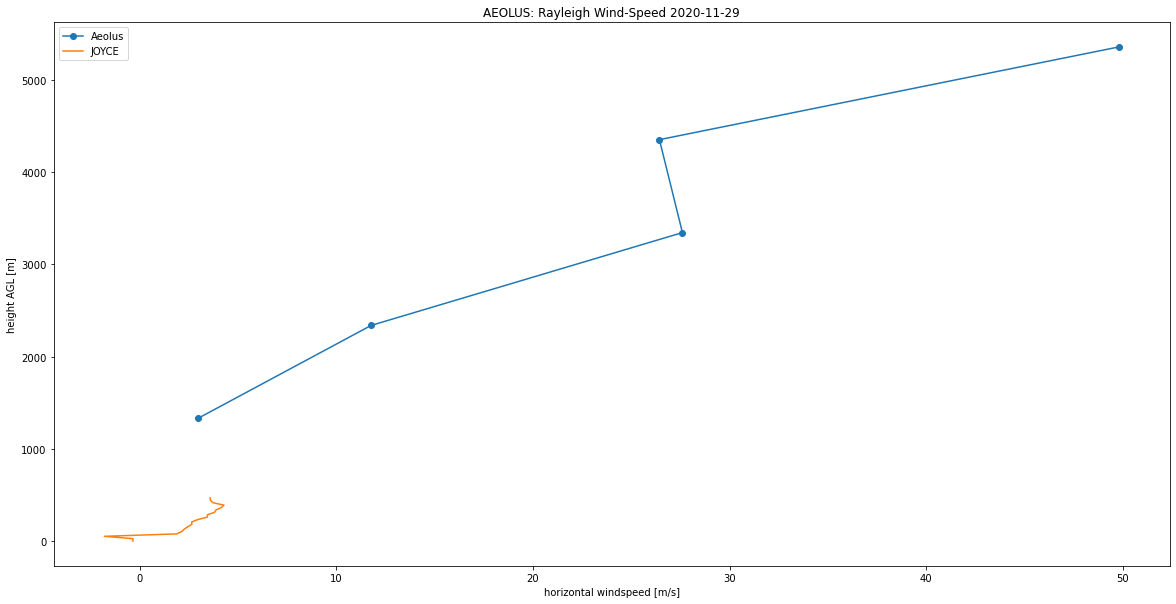

In [19]:
resultGDF2 = resultGDF[resultGDF.validity != 0]
fig = plt.figure(figsize=(20,10))
plt.title("AEOLUS: Rayleigh Wind-Speed "+(x+delta).strftime("%Y-%m-%d"))
ax = plt.axes()

resultGDF2.plot(x="speed", y="alt", ax=ax, label="Aeolus", marker='o')
#resultGDF2.plot(x="validity", y="alt", ax=ax, label="validity")
plt.plot(speed_joyce_hlos, alt_observation, label="JOYCE")
ax.set_xlabel("horizontal windspeed [m/s]")
ax.set_ylabel("height AGL [m]")
ax.legend()
#plt.savefig(path+'plots/'+(x+delta).strftime("%Y-%m-%d")+'_mie2.png',dpi=150)
plt.show()

In [17]:
resultGDF

,column,alt,lat,lon,speed,azimuth,time,validity,geometry
0,1,23905.0,65.071708,0.013776,85.58,256.399575,6.599855e+08,0.0,POINT (0.01378 65.07171)
0,1,22012.0,65.074862,0.044966,327.67,256.428237,6.599855e+08,0.0,POINT (0.04497 65.07486)
0,1,19994.0,65.078011,0.076182,72.16,256.456924,6.599855e+08,0.0,POINT (0.07618 65.07801)
0,1,18481.0,65.103829,0.078208,-9.27,256.471277,6.599855e+08,0.0,POINT (0.07821 65.10383)
0,1,17471.0,65.056913,0.120991,11.15,256.485636,6.599855e+08,0.0,POINT (0.12099 65.05691)
0,1,16463.0,65.106973,0.109492,-32.16,256.500002,6.599855e+08,0.0,POINT (0.10949 65.10697)
0,1,15454.0,65.084296,0.138695,113.15,256.514375,6.599855e+08,0.0,POINT (0.13870 65.08430)
0,1,14446.0,65.110113,0.140804,2.08,256.528754,6.599855e+08,0.0,POINT (0.14080 65.11011)
0,1,13437.0,65.087432,0.169992,126.54,256.543139,6.599855e+08,0.0,POINT (0.16999 65.08743)
0,1,12429.0,65.113248,0.172142,47.54,256.557531,6.599855e+08,0.0,POINT (0.17214 65.11325)
